In [53]:
import concurrent
import gc
import logging
import multiprocessing
import os
import sys
from concurrent import futures
import time

import numpy as np
import pandas as pd
import pyarrow as pa
import scipy.sparse
import scipy.sparse
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
from tiledb import ZstdFilter, ArraySchema, Domain, Dim, Attr, FilterList
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [3]:
dataset_ids_to_query = [ '218acb0f-9f2f-4f76-b90b-15a4b7c7f629',]
dataset_query = '('
for idx, di in enumerate(dataset_ids_to_query): 
    dataset_query += f'dataset_id == "{di}" '
    if idx != len(dataset_ids_to_query)-1:
        dataset_query += 'or '
dataset_query += ')'

celltypes_to_query = [
    'conventional dendritic cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'plasmacytoid dendritic cell, human',
    'dendritic cell',
    'dendritic cell, human',
    'myeloid dendritic cell',
    'plasmacytoid dendritic cell']
celltype_query = '('
for idx, ct in enumerate(celltypes_to_query): 
    celltype_query += f'cell_type == "{ct}" '
    if idx != len(celltypes_to_query)-1:
        celltype_query += 'or '
celltype_query += ')'

OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

In [4]:
# init multiprocessing
start = time.time()
if multiprocessing.get_start_method(True) != "spawn":
    multiprocessing.set_start_method("spawn", True)

exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
layer = "raw"
measurement_name = "RNA"

with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_1),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())

In [5]:
TEST_MODE = bool(os.getenv("TEST_MODE", False))  # Read data from simple test fixture Census data
PROFILE_MODE = bool(os.getenv("PROFILE_MODE", False))  # Run pass 2 in single-process mode with profiling output

ESTIMATORS_CUBE_ARRAY_URI = "estimators_cube"

OBS_WITH_SIZE_FACTOR_TILEDB_ARRAY_URI = "obs_with_size_factor"

TILEDB_SOMA_BUFFER_BYTES = 2**31
if TEST_MODE:
    TILEDB_SOMA_BUFFER_BYTES = 10 * 1024 ** 2

# The minimum number of cells that should be processed at a time by each child process.
MIN_BATCH_SIZE = 2**14
# For testing
MIN_BATCH_SIZE = 20000

CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

if TEST_MODE:
    CUBE_TILEDB_DIMS_OBS = ["celltype"]
    CUBE_TILEDB_ATTRS_OBS = ["study"]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

CUBE_DIMS_VAR = ['feature_id']

if TEST_MODE:
    CUBE_DIMS_VAR = ['var_id']

CUBE_TILEDB_DIMS = CUBE_DIMS_VAR + CUBE_TILEDB_DIMS_OBS

ESTIMATOR_NAMES = ['nnz', 'n_obs', 'min', 'max', 'sum', 'mean', 'sem', 'var', 'sev', 'selv']


CUBE_SCHEMA = ArraySchema(
  domain=Domain(*[
    Dim(name=dim_name, dtype="ascii", filters=FilterList([ZstdFilter(level=-1), ]))
    for dim_name in CUBE_TILEDB_DIMS
  ]),
  attrs=[Attr(name=attr_name, dtype='ascii', nullable=False, filters=FilterList([ZstdFilter(level=-1), ]))
         for attr_name in CUBE_TILEDB_ATTRS_OBS] +
        [Attr(name=estimator_name, dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=-1), ]))
         for estimator_name in ESTIMATOR_NAMES],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=True,
  allows_duplicates=True,
)


In [6]:
obs_df = query.obs().concat().to_pandas()
var_df = query.var().concat().to_pandas()

In [7]:
import scanpy as sc

In [8]:
# adata = query.to_anndata('raw')

In [9]:
# adata.write('temp.h5ad')
adata = sc.read_h5ad('temp.h5ad')

In [10]:
adata.var.index = adata.var.feature_id.values

In [11]:
adata[(adata.obs['donor_id'] == '1031') & (adata.obs['cell_type'] == 'plasmacytoid dendritic cell')].X.todense().shape




(17, 60664)

In [12]:
adata[(adata.obs['donor_id'] == '1031') & (adata.obs['cell_type'] == 'conventional dendritic cell')].X.todense().shape


(60, 60664)

In [13]:
def run_memento(ct1, ct2):
    
    adata = all_adata[all_adata.obs['cell_type'].isin([ct1, ct2])].copy().copy()

    adata.obs['q'] = 0.07
    memento.setup_memento(adata, q_column='q', trim_percent=1, filter_mean_thresh=0.01, shrinkage=0)
    memento.create_groups(adata, label_columns=['cell_type', 'donor_id'])
    memento.compute_1d_moments(adata, min_perc_group=.7)

    meta_df = memento.get_groups(adata)
    meta_df['intercept'] = 1
    covariate = meta_df[['intercept']]
    treatment = (meta_df[['cell_type']] == ct2).astype(float)
        

    memento.ht_1d_moments(
        adata, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=13,
        resample_rep=False,
        approx=True)
    memento_results = memento.get_1d_ht_result(adata)
    
    return memento_results

In [39]:
adata = sc.read_h5ad('temp.h5ad')

In [40]:
donor_list = [
    '1004',
 '1014',
 '1015',
 '1019',
    
    
    
 '1022',
 '1031',
    
    
    
 '1039',
 '1045',
 '1046',
 '1051',
 '1054',
 '1056',
 '1063',
]

In [41]:
test_adata = adata[(adata.obs['donor_id'].isin(donor_list)) ].copy().copy()

In [42]:
test_adata = test_adata[test_adata.obs['cell_type'].isin(['plasmacytoid dendritic cell',  'conventional dendritic cell'])]
test_adata.obs['q'] = 0.07
memento.setup_memento(test_adata, q_column='q', trim_percent=1, filter_mean_thresh=0.01, shrinkage=0, )

/tmp/ipykernel_196051/193996687.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_adata.obs['q'] = 0.07


In [47]:
memento.create_groups(test_adata, label_columns=['cell_type', 'donor_id'])
memento.compute_1d_moments(test_adata, min_perc_group=.6)

In [48]:
meta_df = memento.get_groups(test_adata).astype(str)
# meta_df['intercept'] = 1
treatment = (meta_df[['cell_type']] == 'conventional dendritic cell').astype(float)
covariate = pd.get_dummies(meta_df[['donor_id']], drop_first=True)

covariate -= covariate.mean(axis=0)

interaction_df = covariate*treatment[['cell_type']].values
interaction_df.columns=[f'interaction_{col}' for col in covariate.columns]

covariate = pd.concat([covariate, interaction_df], axis=1)
covariate = sm.add_constant(covariate)



In [49]:
memento.ht_1d_moments(
    test_adata, 
    covariate=covariate,
    treatment=treatment, 
    num_boot=5000, 
    verbose=1,
    num_cpus=13,
    resample_rep=False,
    approx=True)
memento_results = memento.get_1d_ht_result(test_adata)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    5.9s
[Parallel(n_jobs=13)]: Done 467 out of 467 | elapsed:    8.5s finished


<Axes: >

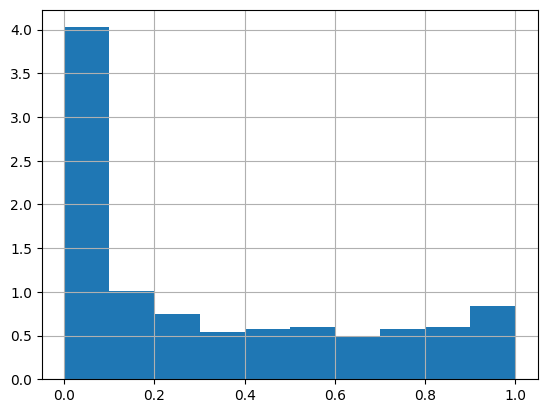

In [50]:
memento_results['de_pval'].hist(density=True)

In [104]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
%autoreload 2

In [50]:
mem_result = run_memento('plasmacytoid dendritic cell',  'conventional dendritic cell')

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=13)]: Done 950 tasks      | elapsed:    1.8s
[Parallel(n_jobs=13)]: Done 2382 out of 2407 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=13)]: Done 2407 out of 2407 | elapsed:    4.3s finished


<Axes: >

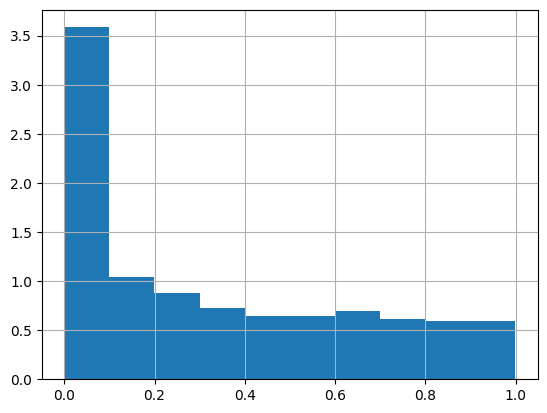

In [52]:
mem_result['de_pval'].hist(density=True)

In [10]:
counts = obs_df.groupby(['dataset_id', 'cell_type']).size().reset_index(name='count')

In [30]:
adata

AnnData object with n_obs × n_vars = 362619 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [14]:
adata[(adata.obs['cell_type'] == 'plasmacytoid dendritic cell')].shape

(5233, 60664)

In [67]:
counts = obs_df.groupby(['dataset_id', 'cell_type']).size().reset_index(name='count')

In [68]:
counts.query('dataset_id == "218acb0f-9f2f-4f76-b90b-15a4b7c7f629"')

,dataset_id,cell_type,count
0,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,conventional dendritic cell,18203
1,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,plasmacytoid dendritic cell,5233


### Composite hypotheses

In [73]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [213]:
# ONE SIDED TEST

num_trials = 10000
num_cells = 500
pop_mean = 0.05
mu = stats.norm.rvs(loc=0, scale=0.1, size=num_trials )
pvalues = np.zeros(num_trials)
tstats = np.zeros(num_trials)
for trial in range(num_trials):
    
    data = stats.norm.rvs(loc=mu[trial], scale=1, size=num_cells)
    tstat, pval = stats.ttest_1samp(data, pop_mean, alternative='greater')
    tstats[trial] = tstat
    pvalues[trial] = pval*2
    

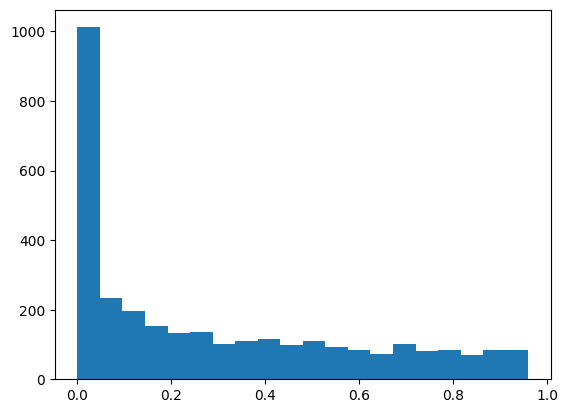

In [214]:
plt.hist(pvalues[tstats > pop_mean], bins=20);

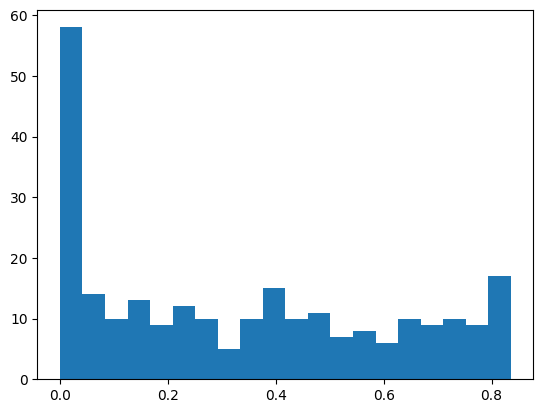

In [194]:
plt.hist(pvalues[tstats > pop_mean], bins=20);